# **Neural Network from scratch**

.

.

In [44]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score, accuracy_score, precision_recall_curve, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings("ignore")

.

## **Define useful functions**

Initializing the weights to zero is not recommended. Andrew Ng (in his the online course about Machine Learning on Coursera) suggests the following initialization:

In [31]:
#Random initialization of weights
def randw(Lin,Lout) :
    np.random.seed(0)
    epsilon = (6 / (Lin+Lout))**0.5;
    return np.random.rand(Lout,Lin+1)*2*epsilon - epsilon

.

The *forward propagation* is useful to fo from the input layer to the output layer.

In [32]:
#Forward propagation
def Forward(X,theta1,theta2,theta3=None) :
    m = X.shape[0]
    a2 = 1./(1.+np.exp(-np.dot(theta1,X.T)))      #a1=X.T
    a3 = 1./(1.+np.exp(-np.dot(theta2,np.vstack([np.ones((1,m)),a2]))))
    if theta3 is None :
        return a3.T
    else :
        a4 = 1./(1.+np.exp(-np.dot(theta3,np.vstack([np.ones((1,m)),a3]))))
        return a4.T

.

The Neural Network training requires the full *forward and back propagation* algorithm to optimize the weights by computing the gradient of the cost function.

In [33]:
#Forward and Backpropagation
def ForwBack(X,theta1,theta2, yy, theta3=None) :
    m = X.shape[0]
    a2 = 1./(1.+np.exp(-np.dot(theta1,X.T)))
    a3 = 1./(1.+np.exp(-np.dot(theta2,np.vstack([np.ones((1,m)),a2]))))
    if theta3 is None :
        d3 = a3-yy.T
        d2 = np.dot(theta2.T,d3) * np.vstack([np.ones((1,m)),a2]) * (1 - np.vstack([np.ones((1,m)),a2]))
        a4, d4 = 0,0
        return a2, a3, a4, d2, d3, d4
    else :
        a4 = 1./(1.+np.exp(-np.dot(theta3,np.vstack([np.ones((1,m)),a3]))))
        d4 = a4-yy.T
        d3 = (np.dot(theta3.T,d4) * np.vstack([np.ones((1,m)),a3]) * (1 - np.vstack([np.ones((1,m)),a3])))[1:,:]
        d2 = (np.dot(theta2.T,d3) * np.vstack([np.ones((1,m)),a2]) * (1 - np.vstack([np.ones((1,m)),a2])))[1:,:]
        return a2, a3, a4, d2, d3, d4

.

Finally, it is possible to create the Cost function and its gradient: in this function, the L2 regularization is added in the code.

In [34]:
#Cost function and Gradient
def J_Grad(theta1, theta2, X, y, hid_layer1, labels, Lambda, theta3 = None, hid_layer2 = None) :
    m = X.shape[0]
    inputs = X.shape[1]
    X = np.hstack([np.ones((X.shape[0],1)),X])
    
    #Create target array
    yy = np.zeros((len(y),labels))
    for i in np.arange(0,m) :
        for k in np.arange(0,labels) :
            if y[i] == k :
                yy[i,k] = 1
    
    a2, a3, a4, d2, d3, d4 = ForwBack(X=X, theta1=theta1, theta2=theta2, theta3=theta3, yy=yy)
    if hid_layer2 is None :
        REG = (np.sum(theta1[:,1:]**2) + np.sum(theta2[:,1:]**2))*Lambda/(2*m)  
        J = sum(sum(-np.log10(a3)*yy.T - np.log10(1-a3)*(1-yy).T))/m + REG
        Delta1 = np.dot(d2,X)[1:,:]       #(d2,a1.T)
        Delta2 = np.dot(d3,(np.vstack([np.ones((1,m)),a2])).T)
        t1grad = (Delta1+(np.hstack([ np.zeros((theta1.shape[0],1)), theta1[:,1:]  ]))*Lambda)/m
        t2grad = (Delta2+(np.hstack([ np.zeros((theta2.shape[0],1)), theta2[:,1:]  ]))*Lambda)/m
        t3grad = 0    
    else :
        REG = (np.sum(theta1[:,1:]**2) + np.sum(theta2[:,1:]**2) + np.sum(theta3[:,1:]**2))*Lambda/(2*m)  
        J = sum(sum(-np.log10(a4)*yy.T - np.log10(1-a4)*(1-yy).T))/m + REG
        Delta1 = np.dot(d2,X)
        Delta2 = np.dot(d3,(np.vstack([np.ones((1,m)),a2])).T)
        Delta3 = np.dot(d4,(np.vstack([np.ones((1,m)),a3])).T)
        t1grad = (Delta1+(np.hstack([ np.zeros((theta1.shape[0],1)), theta1[:,1:]  ]))*Lambda)/m
        t2grad = (Delta2+(np.hstack([ np.zeros((theta2.shape[0],1)), theta2[:,1:]  ]))*Lambda)/m
        t3grad = (Delta3+(np.hstack([ np.zeros((theta3.shape[0],1)), theta3[:,1:]  ]))*Lambda)/m
    return J, t1grad, t2grad, t3grad

.

Once weights have been optimized, the following function returns the final probabilities, predictions, and accuracy.

In [35]:
def Accuracy(theta1, theta2, X, y, theta3 = None) :
    m = X.shape[0]
    inputs = X.shape[1]
    X = np.hstack([np.ones((X.shape[0],1)),X])
    final = Forward(X,theta1,theta2,theta3=theta3)
    Pred = []
    for i in np.arange(0,len(final)) :
        Pred.append(np.argmax(final[i,:]))
    return final[:,1], Pred, (Pred == y).sum()/len(y)

.

All the pieces are ready to write the Neural Network training function that implements the forward and back propagation algorithm up to a *Max_iter* iteration.

The following code includes the *early stopping* part: once the cost function on the validation set reaches its minimum, the algorithm stops to avoid overfitting.

The function return the last iteration epoch, the matrices of weights, the training and validation cost function values at the last iteration, and the corresponding accuracies.

In [36]:
#Training Neural Network
def Training(hid_layer1, X, y, X_test, y_test, alpha, Lambda, Max_iter, hid_layer2 = None, flag = True) :
    inputs = X.shape[1]                     #Number of features
    labels = len(pd.Series(y).unique())     #Number of labels (in the output)
    Cost_te = 100
    if hid_layer2 is None :
        #Random initialization of weights
        theta1 = randw(inputs, hid_layer1)
        theta2 = randw(hid_layer1, labels)
        theta3 = None
    else :
        theta1 = randw(inputs, hid_layer1)
        theta2 = randw(hid_layer1, hid_layer2)
        theta3 = randw(hid_layer2, labels)

    #Iterative training (i: epoch)
    Cost, Cost_t = [], []
    for i in range(Max_iter) :
        A, B, C, D = J_Grad(theta1=theta1, theta2=theta2, theta3=theta3, X=X, y=y, hid_layer1=hid_layer1, hid_layer2=hid_layer2, labels=labels, Lambda=Lambda)
        A1, B1, C1, D1 = J_Grad(theta1=theta1, theta2=theta2, theta3=theta3, X=X_test, y=y_test, hid_layer1=hid_layer1, hid_layer2=hid_layer2, labels=labels, Lambda=0.0)
        EE, E, F = Accuracy(theta1=theta1, theta2=theta2, theta3=theta3, X=X, y=y)
        EE1, E1, F1 = Accuracy(theta1=theta1, theta2=theta2, theta3=theta3, X=X_test, y=y_test)
        Cost.append(A)
        Cost_t.append(A1)
        
        #Early stopping
        broken = 0
        if (flag == True) & (i>100) :        #To avoid initial flactuations
            if A1<Cost_te :
                Cost_te = A1
            else :
                broken = 1
        if broken==1 :
            break
            
        #Update weights
        if hid_layer2 is None :
            theta1 = theta1 - alpha*B
            theta2 = theta2 - alpha*C
        else :
            theta1 = theta1 - alpha*B
            theta2 = theta2 - alpha*C
            theta3 = theta3 - alpha*D
        i=i+1
    return i, theta1, theta2, theta3, Cost, Cost_t, F, F1

.

## **Dataset**

The dataset has been retrieved from https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.names : it is about the *Pima Indians Diabetes*.

In [37]:
#Import the data
data = pd.read_csv("dati2")
data

,A,B,C,D,E,F,G,H,Class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


.

The features are all numeric:
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

In [38]:
#Missing values
print("Number of missing values: {}".format(data.isna().sum().sum()))

Number of missing values: 0


.

The dataset has no missing values. Let's take a look at the target variable:

In [39]:
#Target variable
data.Class.value_counts()

0    500
1    268
Name: Class, dtype: int64

.

It is an unbalanced dataset. In this first part, let's work with a perfectly balanced dataset.

In [40]:
#Create a balanced dataset (268 records for each class)
data = pd.concat([data[data.Class==0].sample(268, random_state=0),data[data.Class==1]])

#Creation of X and y
X = data.drop(["Class"],axis=1)
y = data.Class
X = np.array(X)
y = np.array(y)

.

Before applying the algorithm, let's scale the features.

In [41]:
#Feature scaling
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

.

## **Training (balanced dataset)**

Let's split the dataset into a training and test set (70-30%).

In [42]:
#Training and test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

.

Let's search for the best set of hyperparameters with a grid search. The output will be:
 - Number of units in the hidden layer(s)
 - Learning rate
 - Mean accuracy on the training set (standard deviation)
 - Mean accuracy on the test set (standard deviation)
 - Mean precision
 - Mean recall
 - Mean F1-score

In [14]:
#Grid search
hid_layer1 = [2,3,5]
hid_layer2 = [None, 2,3,5]
learning_rate = [0.5,0.8,1.0]
for i in hid_layer1 :
    for j in hid_layer2 :
        for a in learning_rate :
            acc, acc_te, pre, rec, f1s = [], [], [], [], []
            for k in range(5) :
                #Split Training set into training and validation sets (5 random sampling - bootstrap)
                X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_train,y_train,test_size=0.2,random_state=k)
                q,w,e,r,t,yh,u,p = Training(hid_layer1 = i, hid_layer2 = j, alpha = a, X = X_train_t, y = y_train_t, X_test = X_test_t, y_test = y_test_t, Lambda=0.0, Max_iter = 1000)
                EE, y_pred, F = Accuracy(theta1=w, theta2=e, theta3=r, X=X_test_t, y=y_test_t)
                acc.append(u), acc_te.append(p), pre.append(precision_score(y_test_t, y_pred)), rec.append(recall_score(y_test_t, y_pred)), f1s.append(f1_score(y_test_t, y_pred))
            print("{} - {} - {} ----- {:.3f} ({:.3f}) - {:.3f} ({:.3f}) - {:.3f} - {:.3f} - {:.3f}".format(i,j,a,np.mean(acc),np.std(acc),np.mean(acc_te),np.std(acc_te), 
                                                                                                           np.mean(pre), np.mean(rec),np.mean(f1s)))

2 - None - 0.5 ----- 0.754 (0.005) - 0.712 (0.025) - 0.705 - 0.738 - 0.716
2 - None - 0.8 ----- 0.762 (0.009) - 0.723 (0.013) - 0.705 - 0.774 - 0.734
2 - None - 1.0 ----- 0.765 (0.008) - 0.744 (0.023) - 0.728 - 0.788 - 0.753
2 - 2 - 0.5 ----- 0.518 (0.017) - 0.483 (0.058) - 0.304 - 0.483 - 0.350
2 - 2 - 0.8 ----- 0.535 (0.050) - 0.488 (0.068) - 0.321 - 0.472 - 0.347
2 - 2 - 1.0 ----- 0.582 (0.086) - 0.507 (0.071) - 0.313 - 0.494 - 0.371
2 - 3 - 0.5 ----- 0.744 (0.004) - 0.704 (0.030) - 0.693 - 0.738 - 0.711
2 - 3 - 0.8 ----- 0.757 (0.008) - 0.723 (0.027) - 0.711 - 0.758 - 0.730
2 - 3 - 1.0 ----- 0.754 (0.007) - 0.717 (0.032) - 0.702 - 0.758 - 0.726
2 - 5 - 0.5 ----- 0.718 (0.012) - 0.672 (0.055) - 0.679 - 0.687 - 0.668
2 - 5 - 0.8 ----- 0.762 (0.008) - 0.731 (0.018) - 0.712 - 0.774 - 0.737
2 - 5 - 1.0 ----- 0.760 (0.011) - 0.715 (0.027) - 0.698 - 0.765 - 0.725
3 - None - 0.5 ----- 0.750 (0.008) - 0.717 (0.026) - 0.715 - 0.729 - 0.718
3 - None - 0.8 ----- 0.759 (0.009) - 0.736 (0.010) -

.

The best model (i.e. high validation accuracy, small standard deviation) is:
- Number of units in the first hidden layer: 3
- No second hidden layer
- Learning rate: 1.0

.

Let's take a look at the performance on the Test set: let's plot the cost function for the training and test set to see when early stopping can be applied (flag=False).

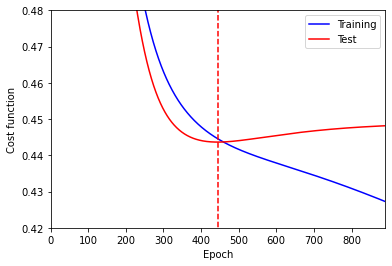

In [43]:
#Performance on the Test set
q,w,e,r,t,yh,u,p = Training(hid_layer1 = 3, hid_layer2 = None, alpha = 1.0, X = X_train, y = y_train, X_test = X_test, y_test = y_test, Lambda=0.0, Max_iter = 1000, flag=False)

#Plot cost functions
plt.plot(t,'blue')
plt.plot(yh,'red')
plt.plot([445,445],[0.3,0.6],'--r')
plt.xlim([0,890])
plt.ylim([0.42,0.48])
plt.xlabel("Epoch")
plt.ylabel("Cost function")
plt.legend(["Training","Test"])

.

At epoch ~450, the Test cost function starts to increase. That is the point where overfit starts.

Now, let's use early stopping in the training function (flag = True).

Last iteration: 445 --- Train accuracy: 76.0% - Test accuracy: 73.91304347826086%

Precision:  0.7702702702702703
Recall:  0.6951219512195121
F1-score:  0.7307692307692307




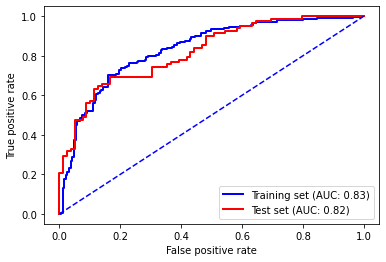

In [47]:
#Performance on the Test set
q,w,e,r,t,yh,u,p = Training(hid_layer1 = 3, hid_layer2 = None, alpha = 1.0, X = X_train, y = y_train, X_test = X_test, y_test = y_test, Lambda=0.0, Max_iter = 5000, flag=True)
print("Last iteration: {} --- Train accuracy: {}% - Test accuracy: {}%".format(q,100*u,100*p))

#Confusion matrix
EE, y_pred, F = Accuracy(theta1=w, theta2=e, X=X_test, y=y_test)
Conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred))
Conf_matrix.index=["Actual 0", "Actual 1"]
Conf_matrix.columns=["Predicted 0", "Predicted 1"]
print("\nPrecision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1-score: ", f1_score(y_test, y_pred))
print("\n")
Conf_matrix

#ROC curves
EE1, y_pred, F = Accuracy(theta1=w, theta2=e, X=X_train, y=y_train)
fpr1, tpr1, thresholds1 = roc_curve(y_train,EE1)
fpr2, tpr2, thresholds2 = roc_curve(y_test,EE)
plt.plot(fpr1, tpr1,'blue',lw=2)
plt.plot(fpr2, tpr2,'red',lw=2)
plt.plot([0,1],[0,1],'--b')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(["Training set (AUC: {:.2f})".format(roc_auc_score(y_train,EE1)),"Test set (AUC: {:.2f})".format(roc_auc_score(y_test,EE))], loc="lower right")

.

For comparison, let's use the Logistic Regression model on the same dataset.



Logistic training accuracy:  0.7546666666666667
Logistic test accuracy:  0.7391304347826086

Precision:  0.7941176470588235
Recall:  0.6585365853658537
F1-score:  0.72




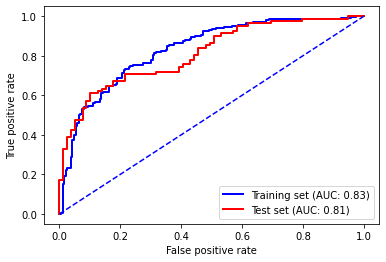

In [48]:
#For comparison: Logistic regression
Model_log = LogisticRegression(penalty="none").fit(X_train,y_train)
print("\n\nLogistic training accuracy: ", Model_log.score(X_train,y_train))
print("Logistic test accuracy: ", Model_log.score(X_test,y_test))
y_pred_log = Model_log.predict(X_test)

#Confusion matrix
Conf_matrix_log = pd.DataFrame(confusion_matrix(y_test, y_pred_log))
Conf_matrix_log.index=["Actual 0", "Actual 1"]
Conf_matrix_log.columns=["Predicted 0", "Predicted 1"]
print("\nPrecision: ", precision_score(y_test, y_pred_log))
print("Recall: ", recall_score(y_test, y_pred_log))
print("F1-score: ", f1_score(y_test, y_pred_log))
print("\n")
Conf_matrix_log

#ROC curves
EE1, y_pred, F = Accuracy(theta1=w, theta2=e, X=X_train, y=y_train)
fpr1, tpr1, thresholds1 = roc_curve(y_train,Model_log.predict_proba(X_train)[:,1])
fpr2, tpr2, thresholds2 = roc_curve(y_test,Model_log.predict_proba(X_test)[:,1])
plt.plot(fpr1, tpr1,'blue',lw=2)
plt.plot(fpr2, tpr2,'red',lw=2)
plt.plot([0,1],[0,1],'--b')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(["Training set (AUC: {:.2f})".format(roc_auc_score(y_train,Model_log.predict_proba(X_train)[:,1])),
            "Test set (AUC: {:.2f})".format(roc_auc_score(y_test,Model_log.predict_proba(X_test)[:,1]))], loc="lower right")

.

Only one small difference between the two models. Finalizing the model:

In [18]:
#For comparison: Logistic regression
Model_log = LogisticRegression(penalty="none").fit(X,y)
print("\nLogistic training accuracy: ", Model_log.score(X,y))


Logistic training accuracy:  0.7406716417910447


.

On the whole dataset, the Logistic regression model accuracy is slighlty lower compared to the Neural Network accuracy on the training set (75%).

.

.

## **Training (unbalanced dataset)**

Now, let's use the whole unbalanced dataset.

In [19]:
#Import data
data = pd.read_csv("dati2")

#Creation of X and y
X = data.drop(["Class"],axis=1)
y = data.Class
X = np.array(X)
y = np.array(y)

#Feature scaling
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

#Training and test set (70-30%)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

#Grid search
hid_layer1 = [2,3,5]
hid_layer2 = [None, 2,3,5]
learning_rate = [0.5,0.8,1.0]
for i in hid_layer1 :
    for j in hid_layer2 :
        for a in learning_rate :
            acc, acc_te, pre, rec, f1s = [], [], [], [], []
            for k in range(5) :
                #Split Training set into training and validation sets (5 random sampling - bootstrap)
                X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_train,y_train,test_size=0.2,random_state=k)
                q,w,e,r,t,yh,u, p = Training(hid_layer1 = i, hid_layer2 = j, alpha = a, X = X_train_t, y = y_train_t, X_test = X_test_t, y_test = y_test_t, Lambda=0.0, Max_iter = 1000)
                EE, y_pred, F = Accuracy(theta1=w, theta2=e, theta3=r, X=X_test_t, y=y_test_t)
                acc.append(u), acc_te.append(p), pre.append(precision_score(y_test_t, y_pred)), rec.append(recall_score(y_test_t, y_pred)), f1s.append(f1_score(y_test_t, y_pred))
            print("{} - {} - {} ----- {:.3f} ({:.3f}) - {:.3f} ({:.3f}) - {:.3f} - {:.3f} - {:.3f}".format(i,j,a,np.mean(acc),np.std(acc),np.mean(acc_te),np.std(acc_te), 
                                                                                                           np.mean(pre), np.mean(rec),np.mean(f1s)))

2 - None - 0.5 ----- 0.754 (0.009) - 0.772 (0.033) - 0.710 - 0.617 - 0.658
2 - None - 0.8 ----- 0.766 (0.007) - 0.772 (0.015) - 0.704 - 0.626 - 0.661
2 - None - 1.0 ----- 0.770 (0.009) - 0.770 (0.009) - 0.698 - 0.626 - 0.658
2 - 2 - 0.5 ----- 0.637 (0.005) - 0.644 (0.019) - 0.000 - 0.000 - 0.000
2 - 2 - 0.8 ----- 0.662 (0.024) - 0.659 (0.026) - 0.355 - 0.086 - 0.137
2 - 2 - 1.0 ----- 0.772 (0.005) - 0.776 (0.022) - 0.703 - 0.647 - 0.672
2 - 3 - 0.5 ----- 0.723 (0.012) - 0.752 (0.042) - 0.714 - 0.508 - 0.587
2 - 3 - 0.8 ----- 0.769 (0.007) - 0.772 (0.023) - 0.697 - 0.641 - 0.667
2 - 3 - 1.0 ----- 0.766 (0.005) - 0.776 (0.026) - 0.704 - 0.647 - 0.672
2 - 5 - 0.5 ----- 0.637 (0.005) - 0.644 (0.019) - 0.000 - 0.000 - 0.000
2 - 5 - 0.8 ----- 0.732 (0.030) - 0.743 (0.056) - 0.702 - 0.520 - 0.583
2 - 5 - 1.0 ----- 0.767 (0.007) - 0.778 (0.021) - 0.708 - 0.647 - 0.673
3 - None - 0.5 ----- 0.767 (0.006) - 0.776 (0.015) - 0.713 - 0.620 - 0.663
3 - None - 0.8 ----- 0.767 (0.007) - 0.783 (0.019) -

.

The best model (i.e. best f1-score) is
- Number of units in the first hidden layer: 3
- Number of units in the second hidden layer: 5
- Learning rate: 0.8

.

Now, it is possible to try to find the threshold that maximizes the f1-score.

Best threshold: 0.36000000000000004
Largest f1-score: 0.7725342894186283


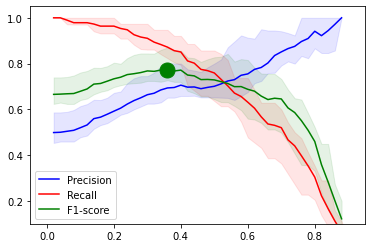

In [108]:
#Repeated random sampling (iterations: 5)
for k in range(5) :
    #Split Training set into training and validation sets (5 random sampling - bootstrap)
    X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_train,y_train,test_size=0.2,random_state=k)
    q,w,e,r,t,yh,u,p = Training(hid_layer1 = 3, hid_layer2 = 5, alpha = 0.8, X = X_train_t, y = y_train_t, X_test = X_test_t, y_test = y_test_t, Lambda=0.0, Max_iter = 3000)
    EE, y_pred, F = Accuracy(theta1=w, theta2=e, theta3=r, X=X_test_t, y=y_test_t)
    
    Thresh = np.arange(0.02,1.02,0.02)
    exec(f"Pre_{k}, Rec_{k} = [],[]")
    Rec = []
    for j in Thresh:
        A = EE.copy()
        i=0
        while i<len(EE) :
            if A[i]>=j :
                A[i] = 1
            else :
                A[i] = 0
            i=i+1
        tn,fp,fn,tp = confusion_matrix(y_test_t,A).ravel()
        precision = tp/(tp + fp)
        recall = tp/(tp + fn)
        exec(f"Pre_{k}.append(precision); Rec_{k}.append(recall)")

#Mean Precision and Recall (for different thresholds)
Prec = np.array(Pre_0)
Reca = np.array(Rec_0)
for k in range(4):
    exec(f"AA = np.array(Pre_{k+1}); BB = np.array(Rec_{k+1})")
    Prec = np.vstack([Prec,AA])
    Reca = np.vstack([Reca,BB])
    
#Threshold that maximizes the F1-score
Index = np.nanargmax(2*(Reca.T.mean(axis=1)*Prec.T.mean(axis=1))/(Reca.T.mean(axis=1)+Prec.T.mean(axis=1)))
print("Best threshold: {}".format(Thresh[Index]))
print("Largest f1-score: {}".format((2*(Reca.T.mean(axis=1)*Prec.T.mean(axis=1))/(Reca.T.mean(axis=1)+Prec.T.mean(axis=1)))[Index]))

#Precision, Recall, and F1-score plot
plt.plot(Thresh, Prec.T.mean(axis=1),'-b')
plt.fill_between(Thresh,Prec.T.min(axis=1),Prec.T.max(axis=1),color='blue',alpha=0.1, label="_nolegend_")
plt.plot(Thresh, Reca.T.mean(axis=1),'-r')
plt.fill_between(Thresh,Reca.T.min(axis=1),Reca.T.max(axis=1),color='red',alpha=0.1, label="_nolegend_")
plt.plot(Thresh, 2*(Reca.T.mean(axis=1)*Prec.T.mean(axis=1))/(Reca.T.mean(axis=1)+Prec.T.mean(axis=1)),'-g')
plt.fill_between(Thresh, 2*(Reca.T.min(axis=1)*Prec.T.min(axis=1))/(Reca.T.min(axis=1)+Prec.T.min(axis=1)),
                 2*(Reca.T.max(axis=1)*Prec.T.max(axis=1))/(Reca.T.max(axis=1)+Prec.T.max(axis=1)), color="green",alpha=0.1)
plt.ylim([0.1,1.05])
plt.xlim([-0.05,0.95])
plt.plot(Thresh[Index], (2*(Reca.T.mean(axis=1)*Prec.T.mean(axis=1))/(Reca.T.mean(axis=1)+Prec.T.mean(axis=1)))[Index],'og',markersize=15)
plt.legend(["Precision","Recall","F1-score"])

.

Let's use the model found above with the new threshold.

Accuracy:  0.7018633540372671

Precision:  0.67
Recall:  0.8170731707317073
F1-score:  0.7362637362637363




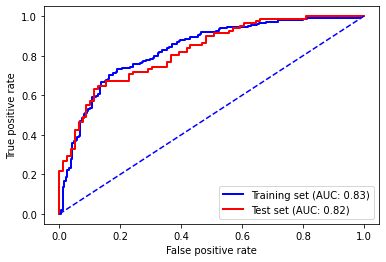

In [55]:
#Model + new threshold
q,w,e,r,t,yh,u,p = Training(hid_layer1 = 3, hid_layer2 = 5, alpha = 0.8, X = X_train, y = y_train, X_test = X_test, y_test = y_test, Lambda=0.0, Max_iter = 5000)
EE, y_pred, F = Accuracy(theta1=w, theta2=e, theta3=r, X=X_test, y=y_test)

#New prediction (based on the new threshold)
Newpred = []
i=0
while i<len(EE) :
    if EE[i]>=Thresh[Index] :
        Newpred.append(1)
    else :
        Newpred.append(0)
    i=i+1
    
#Confusion matrix
Conf_matrix = pd.DataFrame(confusion_matrix(y_test, Newpred))
Conf_matrix.index=["Actual 0", "Actual 1"]
Conf_matrix.columns=["Predicted 0", "Predicted 1"]
print("Accuracy: ", accuracy_score(y_test, Newpred))
print("\nPrecision: ", precision_score(y_test, Newpred))
print("Recall: ", recall_score(y_test, Newpred))
print("F1-score: ", f1_score(y_test, Newpred))
print("\n")
Conf_matrix


#ROC curves
EE1, y_pred2, F = Accuracy(theta1=w, theta2=e, X=X_train, y=y_train)
fpr1, tpr1, thresholds1 = roc_curve(y_train,EE1)
fpr2, tpr2, thresholds2 = roc_curve(y_test,EE)
plt.plot(fpr1, tpr1,'blue',lw=2)
plt.plot(fpr2, tpr2,'red',lw=2)
plt.plot([0,1],[0,1],'--b')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(["Training set (AUC: {:.2f})".format(roc_auc_score(y_train,EE1)),"Test set (AUC: {:.2f})".format(roc_auc_score(y_test,EE))], loc="lower right")

In [56]:
#Confusion matrix (no threshold modification)
Conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred))
Conf_matrix.index=["Actual 0", "Actual 1"]
Conf_matrix.columns=["Predicted 0", "Predicted 1"]
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("\nPrecision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1-score: ", f1_score(y_test, y_pred))
print("\n")
Conf_matrix

Accuracy:  0.7267080745341615

Precision:  0.7567567567567568
Recall:  0.6829268292682927
F1-score:  0.7179487179487181




,Predicted 0,Predicted 1
Actual 0,61,18
Actual 1,26,56


.

Without the threshold modification, the accuracy on the test set is higher. However, the number of true positives is lower.

.

For comparison, let's use the Logistic regression model (no threshold modification).



Logistic training accuracy:  0.7546666666666667
Logistic test accuracy:  0.7391304347826086

Precision:  0.7941176470588235
Recall:  0.6585365853658537
F1-score:  0.72




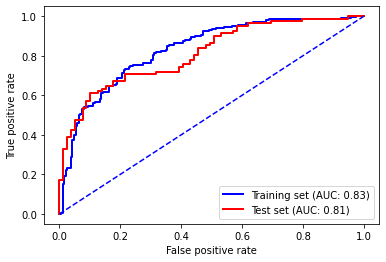

In [58]:
#Logistic regression
Model_log = LogisticRegression(penalty="none").fit(X_train,y_train)
print("\n\nLogistic training accuracy: ", Model_log.score(X_train,y_train))
print("Logistic test accuracy: ", Model_log.score(X_test,y_test))
y_pred_log = Model_log.predict(X_test)

#Confusion matrix
Conf_matrix_log = pd.DataFrame(confusion_matrix(y_test, y_pred_log))
Conf_matrix_log.index=["Actual 0", "Actual 1"]
Conf_matrix_log.columns=["Predicted 0", "Predicted 1"]
print("\nPrecision: ", precision_score(y_test, y_pred_log))
print("Recall: ", recall_score(y_test, y_pred_log))
print("F1-score: ", f1_score(y_test, y_pred_log))
print("\n")
Conf_matrix_log

#ROC curves
EE1, y_pred, F = Accuracy(theta1=w, theta2=e, X=X_train, y=y_train)
fpr1, tpr1, thresholds1 = roc_curve(y_train,Model_log.predict_proba(X_train)[:,1])
fpr2, tpr2, thresholds2 = roc_curve(y_test,Model_log.predict_proba(X_test)[:,1])
plt.plot(fpr1, tpr1,'blue',lw=2)
plt.plot(fpr2, tpr2,'red',lw=2)
plt.plot([0,1],[0,1],'--b')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(["Training set (AUC: {:.2f})".format(roc_auc_score(y_train,Model_log.predict_proba(X_train)[:,1])),
            "Test set (AUC: {:.2f})".format(roc_auc_score(y_test,Model_log.predict_proba(X_test)[:,1]))], loc="lower right")

.

As before, higher accuracy but smaller number of true positives; and finalyzing the model: